In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import pandas as pd
from sklearn.feature_selection import RFECV
import sklearn.metrics as sm
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from matplotlib import style
import seaborn as sns
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)

In [2]:
# extra imports
from numpy.random import uniform, normal
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

In [29]:
df=pd.read_csv('X_train.csv')
df.head()

,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Views,Likes,Comments,Licensed,official_video,ifTop100,trackLength,albumLength,ArtistEqualsChannel,album_tracks,available_markets,album_release_days,Album_type_album,Album_type_compilation,Album_type_single,target
0,0.407,0.358,9.0,-12.908,0.0343,0.829,0.424000,0.0827,0.267,92.292,284800.0,29700954.0,121515.0,4260.0,0.0,0.0,0,11,7,0,9,184,19183,1,0,0,78507272.0
1,0.463,0.325,11.0,-14.762,0.0301,0.197,0.000000,0.0641,0.386,135.728,283133.0,1159190.0,3822.0,84.0,0.0,0.0,0,22,12,0,10,2,11778,1,0,0,134634501.0
2,0.253,0.189,8.0,-17.741,0.0348,0.856,0.000004,0.1120,0.143,133.591,152000.0,3309.0,31.0,3.0,0.0,0.0,1,55,33,0,12,25,22005,1,0,0,18549494.0
3,0.828,0.539,1.0,-7.300,0.2250,0.205,0.000038,0.3050,0.680,125.050,189171.0,460685.0,19970.0,817.0,0.0,1.0,0,12,12,1,1,183,64,0,0,1,1146962.0
4,0.395,0.288,11.0,-10.465,0.0345,0.656,0.000000,0.1160,0.189,130.571,238640.0,1870346.0,22327.0,1097.0,1.0,1.0,0,47,20,0,15,184,694,1,0,0,70267624.0


In [26]:
from sklearn.preprocessing import StandardScaler

In [31]:
Y=df['target'].values
X=df.drop(['target'],axis=1)

In [32]:
from scipy import stats
def boxcoxTransformation(data,column):
    # transform training data & save lambda value
    fitted_data, fitted_lambda = stats.boxcox(data)
    print(f"Lambda value used for Transformation: {fitted_lambda}")
    return fitted_data, fitted_lambda

In [33]:
columns_box=['Duration_ms','Views','Likes','Comments','album_release_days']
transformed_columns=[]
for col in columns_box:
    fitted_data, fitted_lambda=boxcoxTransformation(X[col]+1,col)
    X[col]=fitted_data
fitted_data, fitted_lambda=boxcoxTransformation(Y+1,'Stream')
Y=fitted_data

Lambda value used for Transformation: 0.31773056685911044
Lambda value used for Transformation: 0.10156044067199684
Lambda value used for Transformation: 0.10579676188111083
Lambda value used for Transformation: 0.08847159794297911
Lambda value used for Transformation: 0.17700912618853393
Lambda value used for Transformation: 0.10579596085309491


In [34]:
k=10
# Create indices for k-fold cross-validation
indices = np.arange(len(X))
np.random.shuffle(indices)

# Split the data into k folds
folds = np.array_split(indices, k)

In [35]:
test_indices = folds[0]
train_indices = np.concatenate([folds[j] for j in range(k) if j != 0])

X_train, y_train = X.loc[train_indices], Y[train_indices]
X_test, y_test = X.loc[test_indices], Y[test_indices]

###  Linear Regression Model

In [36]:
p = 1                   # smallest degree to try
q = 26                  # largest degree to try  (minus 1, see code below)

coef = []               # holds coefficients of trained polynomials from degree p=1 up to q=26
model = []              # holds trained polynomials from degree p=1 up to q=26
norm_mse_train = []     # holds training error for trained polynomials from degree p=1 up to q=26
norm_mse_valid = []     # holds validation error for trained polynomials from degree p=1 up to q=26

for i in range(p, q):
    cmodel = LinearRegression()
    cmodel.fit(X_train, y_train)
    coef.append(cmodel.coef_)
    
    # compute training error as mse on training data
    predictions = cmodel.predict(X_train)  
    norm_mse_train.append(mean_squared_error(predictions, y_train))
    
    # compute validation error as mse on validation data
    pred_val = cmodel.predict(X_test)  
    norm_mse_valid.append(mean_squared_error(pred_val, y_test))
    
    model.append(cmodel)
0;

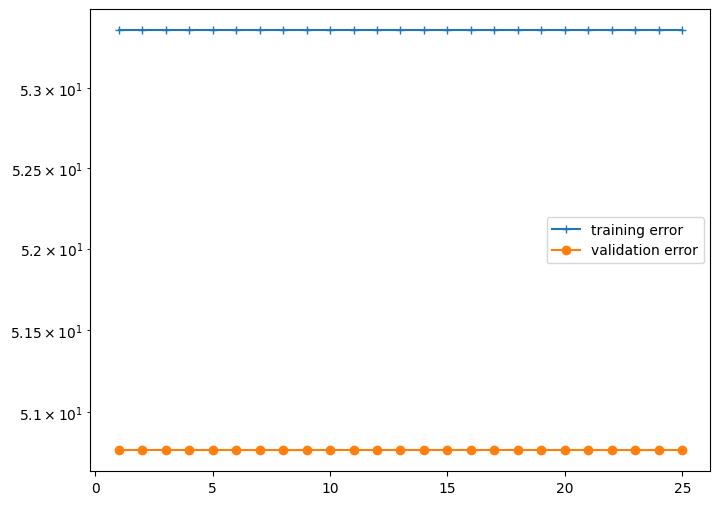

In [37]:
maxdeg = 25
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1, maxdeg+1), norm_mse_train[0:maxdeg], '-+', label='training error')
plt.plot(range(1, maxdeg+1), norm_mse_valid[0:maxdeg], '-o', label='validation error')
plt.yscale('log')
plt.legend();

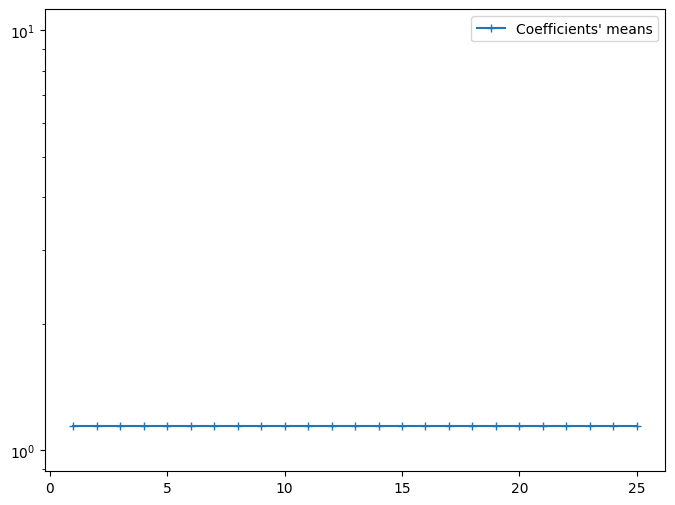

In [38]:
maxdeg = 25
means = [np.mean(np.abs(m.coef_)) for m in model]

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1, maxdeg+1), means[0:maxdeg], '-+', label = "Coefficients' means")
plt.yscale('log')
plt.legend();

In [45]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import *

degree=1
# Instance

# Fit Linear model with poly features
model = LinearRegression().fit(X_train,y_train)
poly_pred = model.predict(X_test)

mse=mean_squared_error(y_test, poly_pred, squared=False)
print('MSE:', mse )
# RMSE
rmse = np.sqrt( mean_squared_error(y_test, pred))
print('RMSE:', rmse )

mae = np.sqrt( mean_absolute_error(y_test, pred))
print('MAE:', mae )

r2=r2_score(y_test, pred)
print('R2:', r2 )

MSE: 7.125337806325739
RMSE: 7.125337806325739
MAE: 2.366502419898855
R2: 0.5232474955776822


### Multivariate Polynomial Regression Model

In [41]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import *

degree=3
# Instance
poly2 = PolynomialFeatures(degree=degree, include_bias=False)
X_poly = poly2.fit_transform(X_train)
# Fit Linear model with poly features
poly_model = LinearRegression().fit(X_poly,y_train)

X_test_poly = poly2.fit_transform(X_test)
poly_pred = poly_model.predict(X_test_poly)

mse=mean_squared_error(y_test, poly_pred, squared=False)
print('MSE:', mse )
# RMSE
rmse = np.sqrt( mean_squared_error(y_test, poly_pred))
print('RMSE:', rmse )

mae = np.sqrt( mean_absolute_error(y_test, poly_pred))
print('MAE:', mae )
r2=r2_score(y_test, poly_pred)
print('R2:', r2 )

MSE: 10.529944202504748
RMSE: 10.529944202504748
MAE: 2.4962824621236535
R2: -0.041200110387686895


In [44]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import *

degree=2
# Instance
poly2 = PolynomialFeatures(degree=degree, include_bias=False)
X_poly = poly2.fit_transform(X_train)
# Fit Linear model with poly features
poly_model = LinearRegression().fit(X_poly,y_train)

X_test_poly = poly2.fit_transform(X_test)
poly_pred = poly_model.predict(X_test_poly)

mse=mean_squared_error(y_test, poly_pred, squared=False)
print('MSE:', mse )
# RMSE
rmse = np.sqrt( mean_squared_error(y_test, poly_pred))
print('RMSE:', rmse )

mae = np.sqrt( mean_absolute_error(y_test, poly_pred))
print('MAE:', mae )

r2=r2_score(y_test, poly_pred)
print('R2:', r2 )

MSE: 8.184558492795874
RMSE: 8.184558492795874
R2: 0.3923186674802288


In [43]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import *

degree=1
# Instance
poly2 = PolynomialFeatures(degree=degree, include_bias=False)
X_poly = poly2.fit_transform(X_train)
# Fit Linear model with poly features
poly_model = LinearRegression().fit(X_poly,y_train)

X_test_poly = poly2.fit_transform(X_test)
poly_pred = poly_model.predict(X_test_poly)

mse=mean_squared_error(y_test, poly_pred, squared=False)
print('MSE:', mse )
# RMSE
rmse = np.sqrt( mean_squared_error(y_test, poly_pred))
print('RMSE:', rmse )

mae = np.sqrt( mean_absolute_error(y_test, poly_pred))
print('MAE:', mae )


r2=r2_score(y_test, poly_pred)
print('R2:', r2 )

MSE: 7.12533780632574
RMSE: 7.12533780632574
MAE: 2.3665024198988567
R2: 0.523247495577682


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c6bca811-fc7a-456b-b8f3-4c66c733d95a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>